In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 3.4/150.0 MB 22.3 MB/s eta 0:00:07
   -- ------------------------------------- 10.2/150.0 MB 29.0 MB/s eta 0:00:05
   ----- ---------------------------------- 19.4/150.0 MB 34.0 MB/s eta 0:00:04
   -------- ------------------------------- 30.7/150.0 MB 38.9 MB/s eta 0:00:04
   ----------- ---------------------------- 44.3/150.0 MB 44.0 MB/s eta 0:00:03
   --------------- ------------------------ 59.0/150.0 MB 48.8 MB/s eta 0:00:02
   ------------------- -------------------- 72.9/150.0 MB 51.6 MB/s eta 0:00:02
   ----------------------- ---------------- 86.8/150.0 MB 53.2 MB/s eta 0:00:02
   -------------------------- ------------ 100.9/150.0 MB 55.1 MB/s eta 0:00:01
   ----------------------------- --------- 113.5/150.0 MB 55.8 MB/s eta 0:00:01
   -------------------------------- ------ 126.9/150.0 MB 57.1 MB/s eta 0:00:01
   ------------------------------------ -- 142.1/1

In [12]:
!pip install tensorflow

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 2.1/376.0 MB 13.1 MB/s eta 0:00:29
    --------------------------------------- 5.8/376.0 MB 15.3 MB/s eta 0:00:25
   - -------------------------------------- 10.7/376.0 MB 18.7 MB/s eta 0:00:20
   - -------------------------------------- 16.3/376.0 MB 20.9 MB/s eta 0:00:18
   -- ------------------------------------- 24.9/376.0 MB 25.0 MB/s eta 0:00:15
   --- ------------------------------------ 34.9/376.0 MB 29.2 MB/s eta 0:00:12
   ---- ----------------------------------- 45.9/376.0 MB 32.8 MB/s eta 0:00:11
   ------ --------------------------------- 56.9/376.0 MB 35.5 MB/s eta 0:00:09
   ------- -------------------------------- 68.2/376.0 MB 37.5 MB/s eta 0:00:09
   -------- ------------------------------- 78.9/376.0 MB 39.3 MB/s eta 0:00:08
   --------- ------------------------------ 90.2/376.0 MB 40.5 MB/s eta 0:00:08
   ---------- ---------------------------- 101.4/37


Processing case: 600FF
R²: 0.655, MAE: 7.37°C


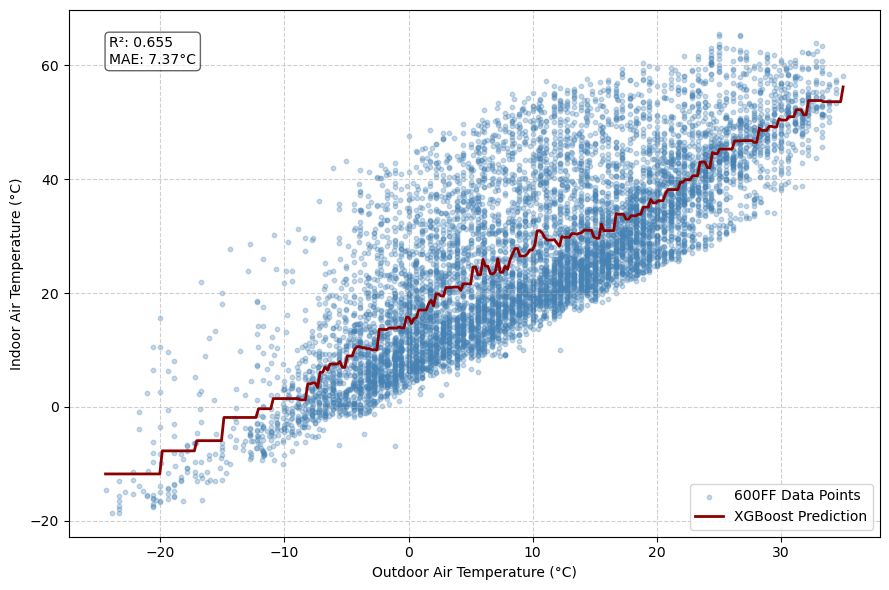

C:\Users\prigm\AppData\Local\Temp\ipykernel_33148\2232283282.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


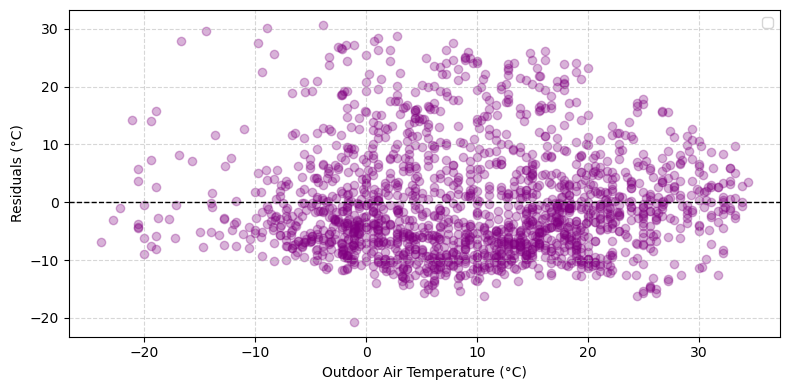


Processing case: 650FF
R²: 0.629, MAE: 8.34°C


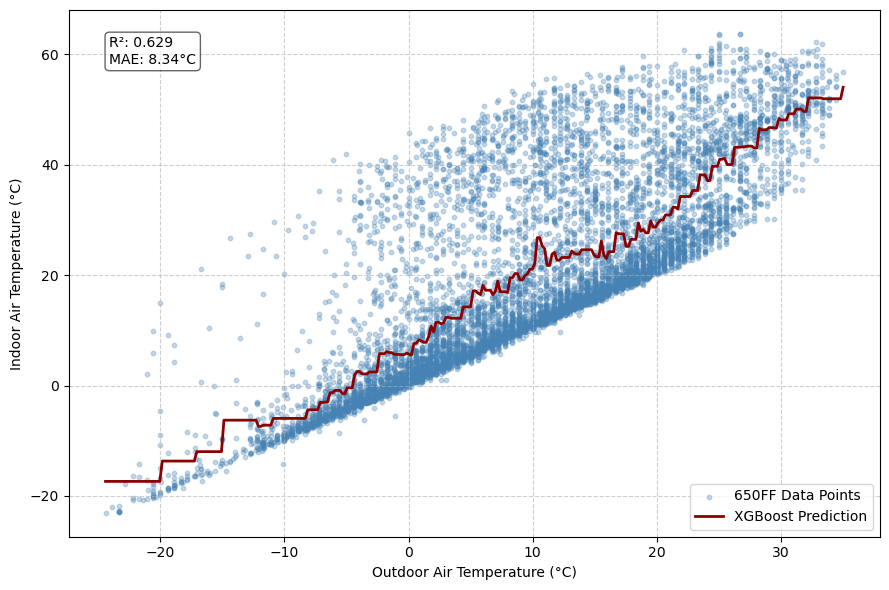

C:\Users\prigm\AppData\Local\Temp\ipykernel_33148\2232283282.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


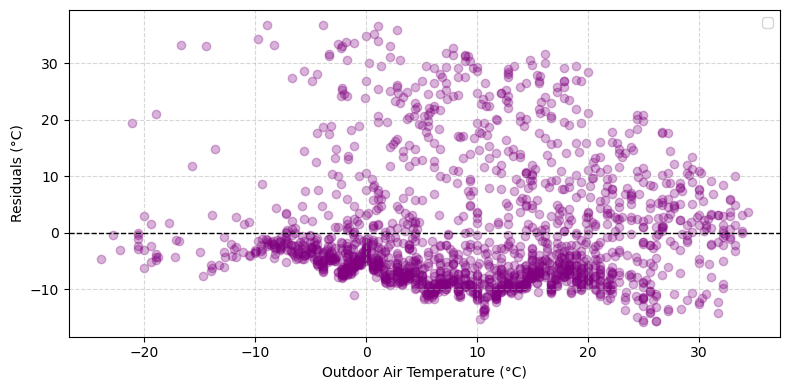


Processing case: 900FF
R²: 0.812, MAE: 3.14°C


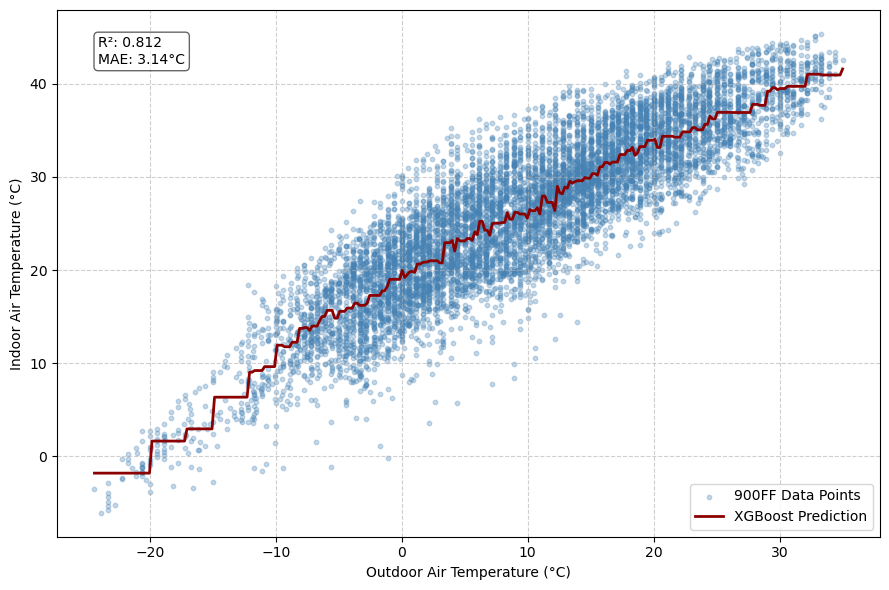

C:\Users\prigm\AppData\Local\Temp\ipykernel_33148\2232283282.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


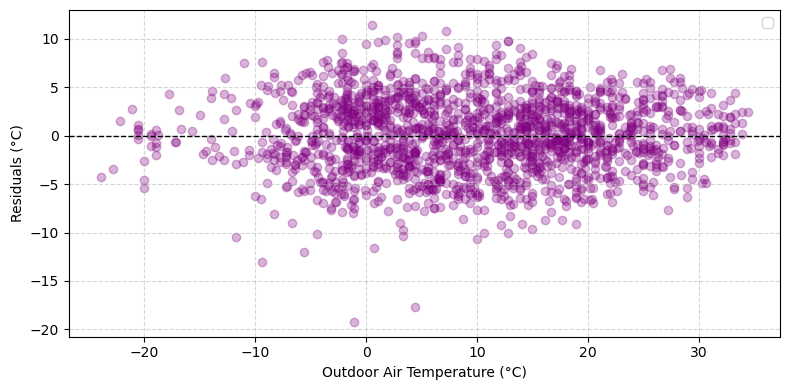


Processing case: 950FF
R²: 0.927, MAE: 2.03°C


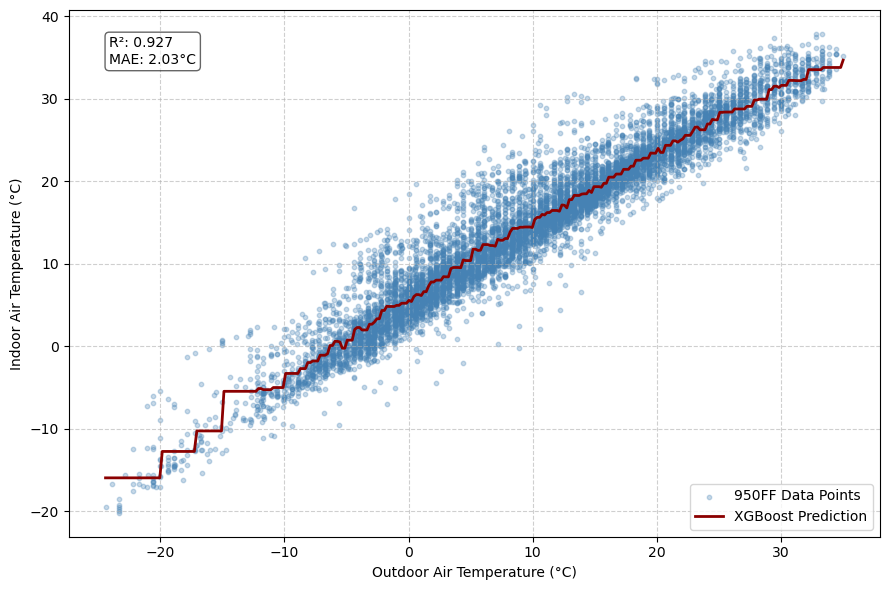

C:\Users\prigm\AppData\Local\Temp\ipykernel_33148\2232283282.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


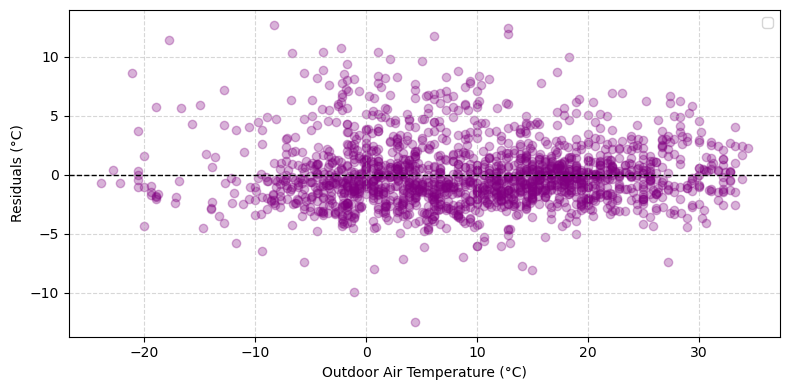

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

cases = ["600FF1.08.xlsx", "650FF1.08.xlsx", "900FF1.08.xlsx", "950FF1.08.xlsx"]
labels = ["600FF", "650FF", "900FF", "950FF"]

for file, label in zip(cases, labels):
    print(f"\nProcessing case: {label}")
    df = pd.read_excel(file, sheet_name="Model_grey-box3")
    x = pd.to_numeric(df["te"], errors="coerce")         # Outdoor temp
    y = pd.to_numeric(df["tair,model"], errors="coerce") # Indoor temp
    df = pd.DataFrame({"x": x, "y": y}).dropna()
    X_train, X_test, y_train, y_test = train_test_split(
        df["x"].values.reshape(-1, 1), df["y"].values, test_size=0.2, random_state=42
    )

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    params = {
        "objective": "reg:squarederror",
        "max_depth": 3,
        "eta": 0.1,
        "verbosity": 0
    }
    model = xgb.train(params, dtrain, num_boost_round=100)
    y_pred = model.predict(dtest)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"R²: {r2:.3f}, MAE: {mae:.2f}°C")

    # prediction curve smoothing
    x_range = np.linspace(df["x"].min(), df["x"].max(), 300).reshape(-1, 1)
    dplot = xgb.DMatrix(x_range)
    y_range_pred = model.predict(dplot)

    # Plot 1: Prediction
    plt.figure(figsize=(9, 6))
    plt.scatter(df["x"], df["y"], alpha=0.3, color="steelblue", label= f"{label} Data Points", s=10)
    plt.plot(x_range, y_range_pred, color="darkred", linewidth=2, label="XGBoost Prediction")
    plt.text(0.05, 0.95, f"R²: {r2:.3f}\nMAE: {mae:.2f}°C",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.6))
    plt.xlabel("Outdoor Air Temperature (°C)")
    plt.ylabel("Indoor Air Temperature (°C)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"{label}_XGBoost_Prediction.png", dpi=300)
    plt.show()

    # Plot 2: Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 4))
    plt.scatter(X_test, residuals, alpha=0.3, color='purple')
    plt.axhline(0, linestyle='--', color='black', linewidth=1)
    #plt.title(f"Residuals: {label} (Indoor - Predicted)")
    plt.xlabel("Outdoor Air Temperature (°C)")
    plt.ylabel("Residuals (°C)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{label}_XGBoost_Residuals.png", dpi=300)
    plt.show()


Processing case: 600FF
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
R²: 0.639, MAE: 7.52°C


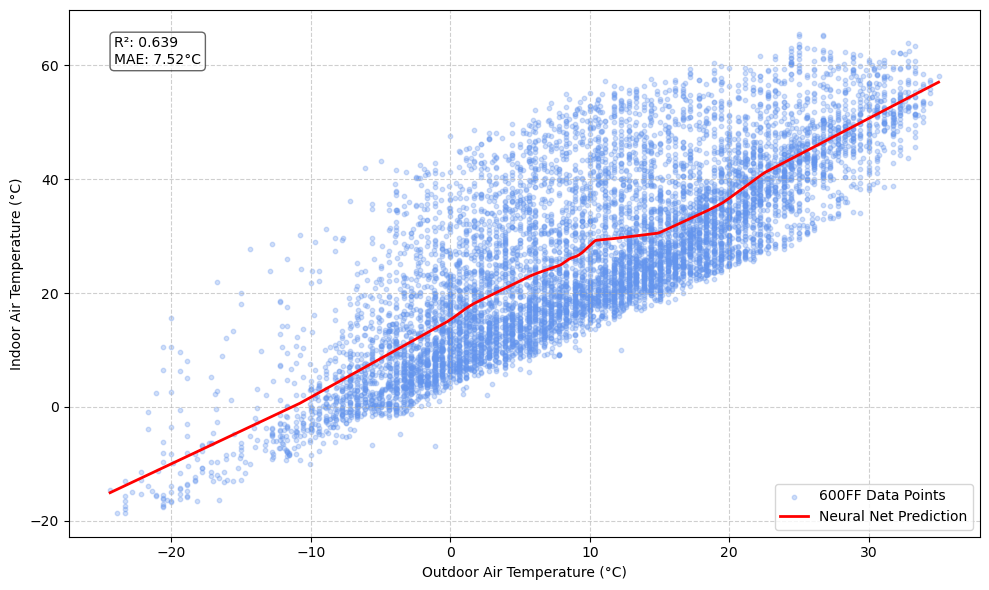

C:\Users\prigm\AppData\Local\Temp\ipykernel_2248\664602919.py:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


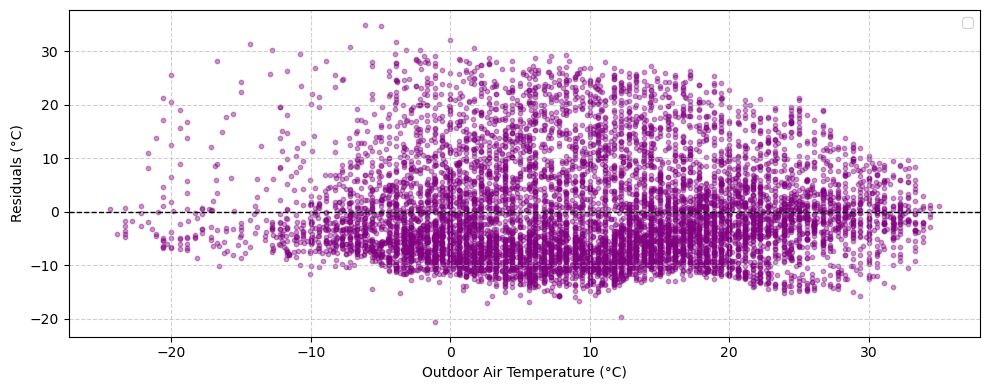

Processing case: 650FF
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
R²: 0.614, MAE: 8.44°C


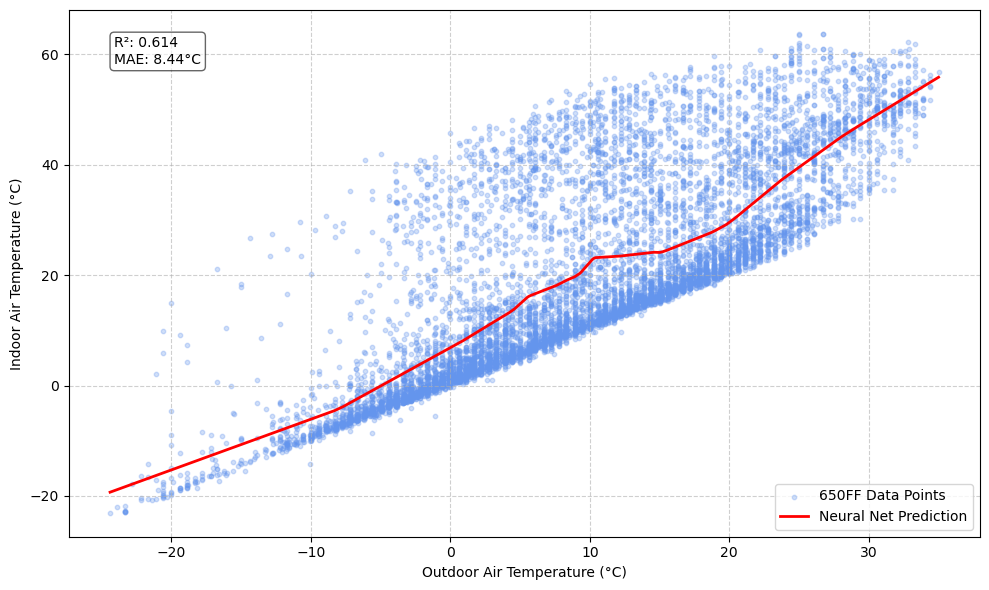

C:\Users\prigm\AppData\Local\Temp\ipykernel_2248\664602919.py:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


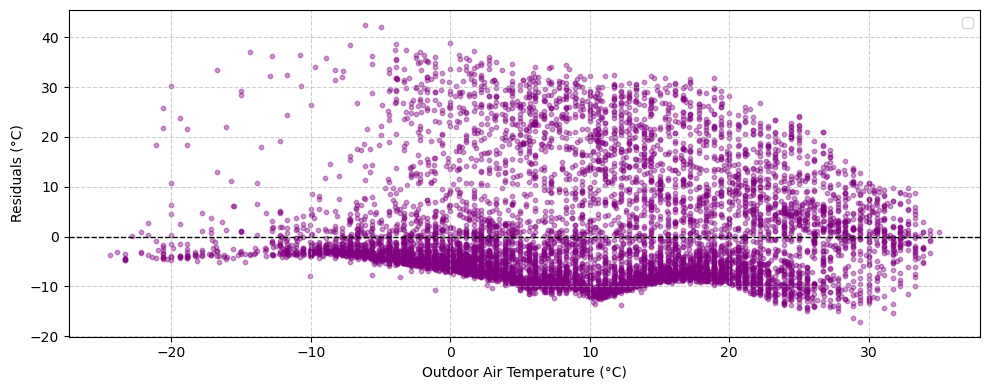

Processing case: 900FF
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
R²: 0.794, MAE: 3.19°C


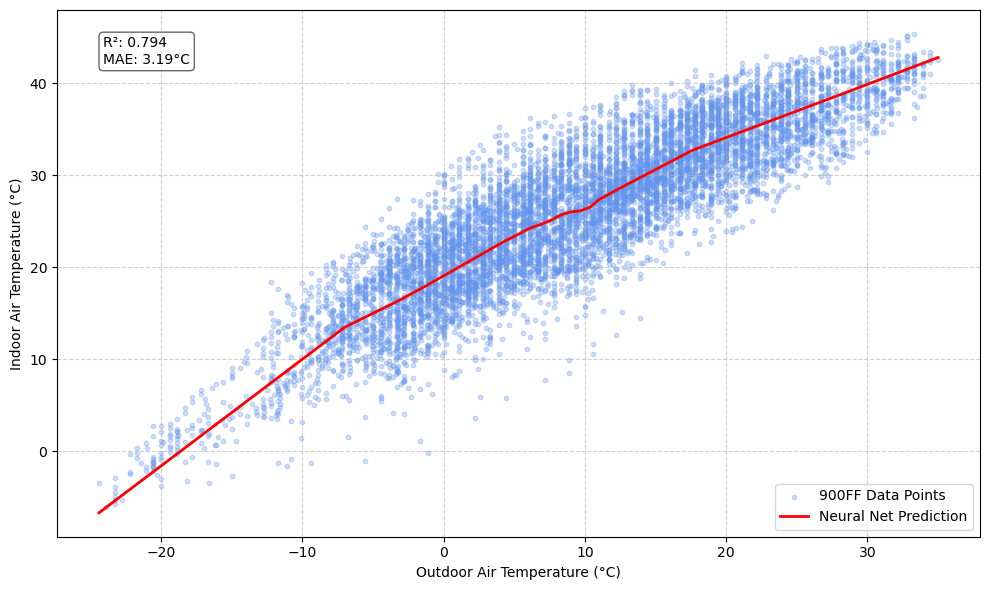

C:\Users\prigm\AppData\Local\Temp\ipykernel_2248\664602919.py:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


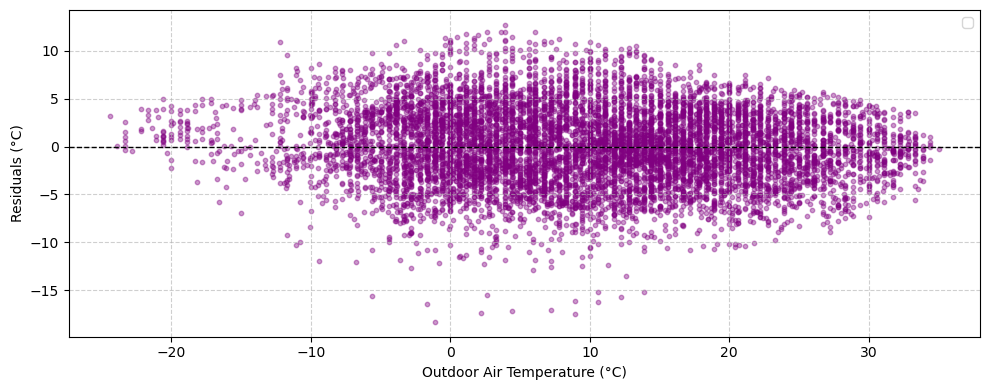

Processing case: 950FF
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R²: 0.924, MAE: 2.00°C


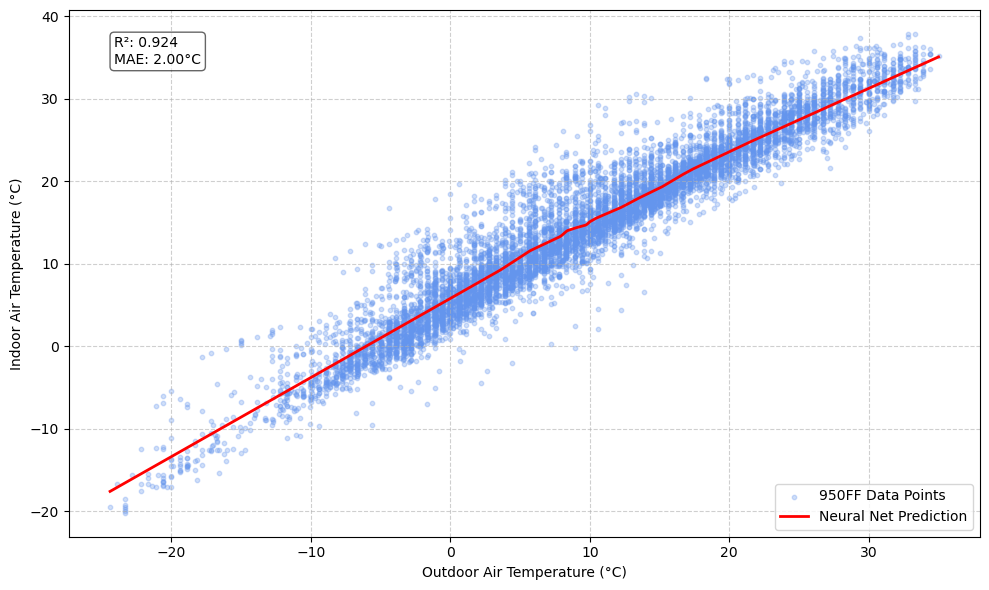

C:\Users\prigm\AppData\Local\Temp\ipykernel_2248\664602919.py:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


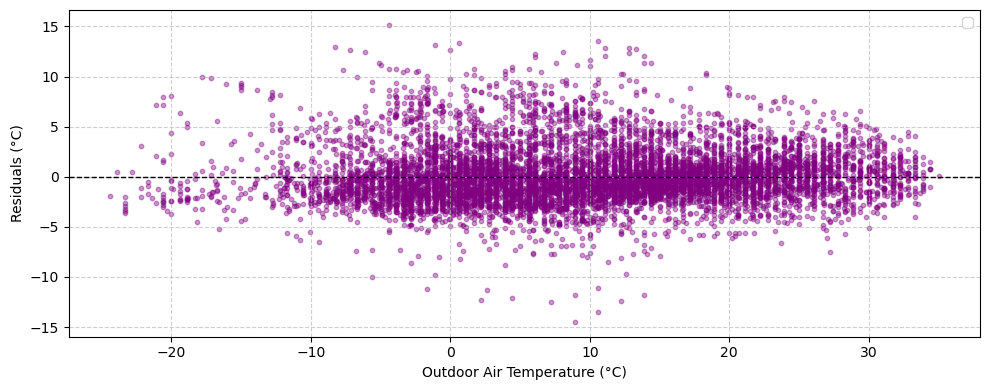

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

cases = ["600FF1.08.xlsx", "650FF1.08.xlsx", "900FF1.08.xlsx", "950FF1.08.xlsx"]
labels = ["600FF", "650FF", "900FF", "950FF"]

for file, label in zip(cases, labels):
    print(f"Processing case: {label}")
    df = pd.read_excel(file, sheet_name="Model_grey-box3")
    outdoor_temp = pd.to_numeric(df["te"], errors="coerce")  # Column Q
    indoor_temp = pd.to_numeric(df["tair,model"], errors="coerce")  # Column AB
    valid = ~outdoor_temp.isna() & ~indoor_temp.isna()
    X = outdoor_temp[valid].values.reshape(-1, 1)
    y = indoor_temp[valid].values.reshape(-1, 1)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    model = Sequential([
        Input(shape=(1,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_scaled, y_scaled, epochs=100, verbose=0)

    y_pred_scaled = model.predict(X_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_true = y.flatten()

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"R²: {r2:.3f}, MAE: {mae:.2f}°C")

    sorted_idx = X.flatten().argsort()
    X_sorted = X.flatten()[sorted_idx]
    y_pred_sorted = y_pred[sorted_idx]
    upper_sorted = upper[sorted_idx]
    lower_sorted = lower[sorted_idx]

    # Plot OF PREDICTIONS
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.3, label=f"{label} Data Points", color="cornflowerblue", s=10)
    plt.plot(X_sorted, y_pred_sorted, color='red', linewidth=2, label="Neural Net Prediction")
    plt.text(0.05, 0.95, f"R²: {r2:.3f}\nMAE: {mae:.2f}°C",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.6))
    plt.xlabel("Outdoor Air Temperature (°C)")
    plt.ylabel("Indoor Air Temperature (°C)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{label}_NN_Prediction.png", dpi=300)
    plt.show()

    # Plot of residuals 
    plt.figure(figsize=(10, 4))
    plt.scatter(X, residuals, alpha=0.4, color='purple', s=10)
    plt.axhline(0, linestyle='--', color='black', linewidth=1)
    #plt.title(f"Residuals: {label} (Indoor - Predicted)")
    plt.xlabel("Outdoor Air Temperature (°C)")
    plt.ylabel("Residuals (°C)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{label}_NN_Residuals.png", dpi=300)
    plt.show()
    


Processing case: 600FF
R²: 0.654, MAE: 7.37°C


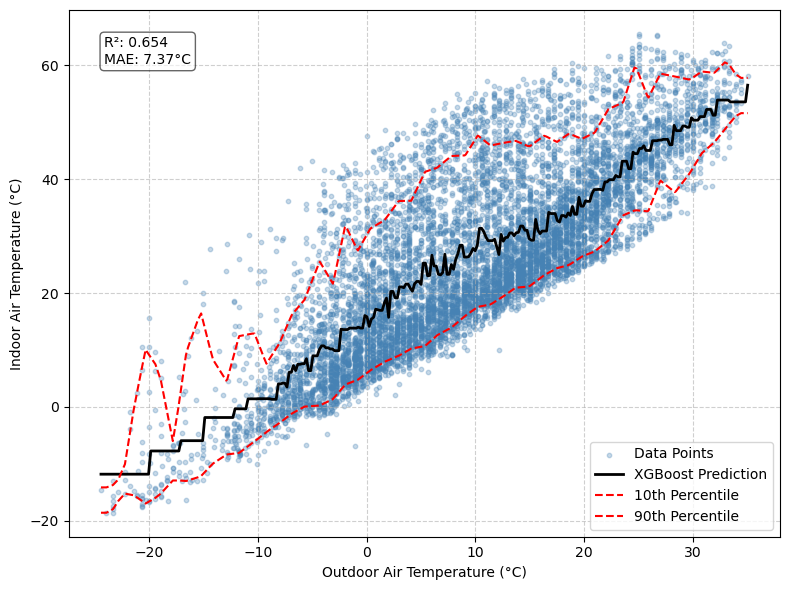


Processing case: 650FF
R²: 0.628, MAE: 8.36°C


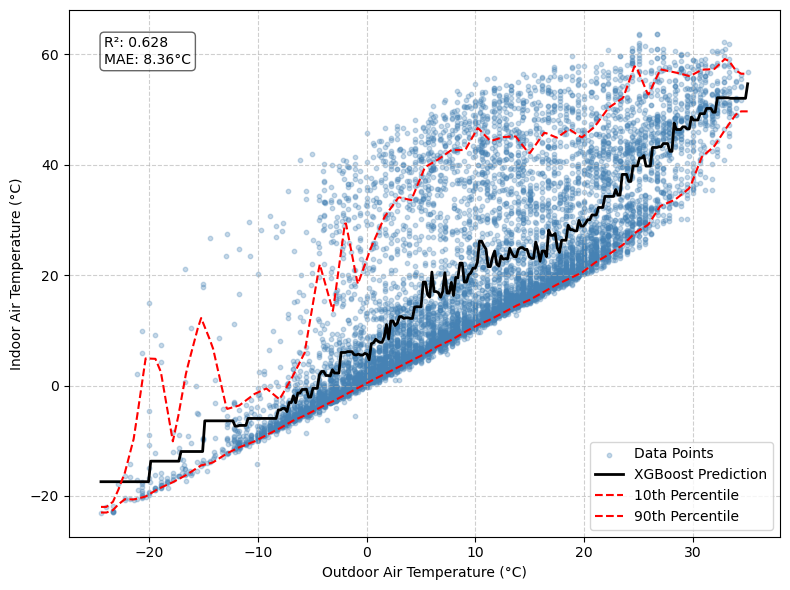


Processing case: 900FF
R²: 0.813, MAE: 3.13°C


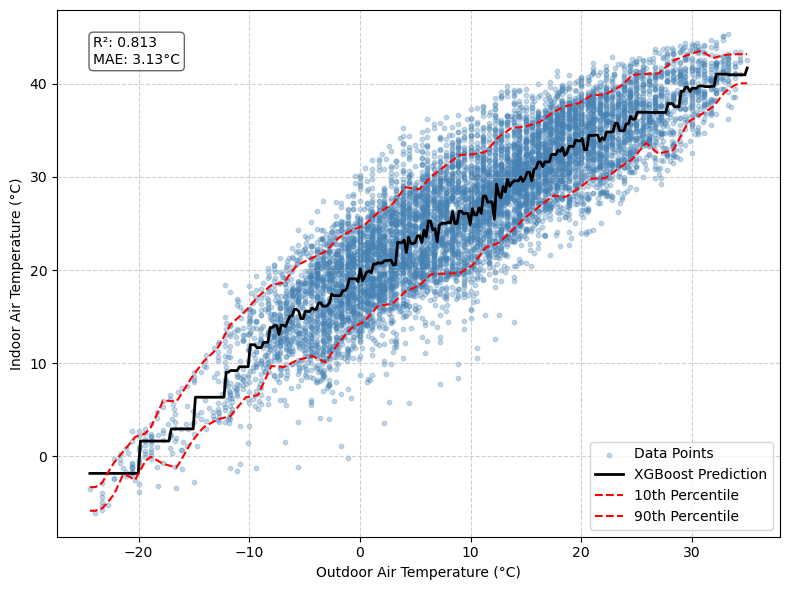


Processing case: 950FF
R²: 0.927, MAE: 2.02°C


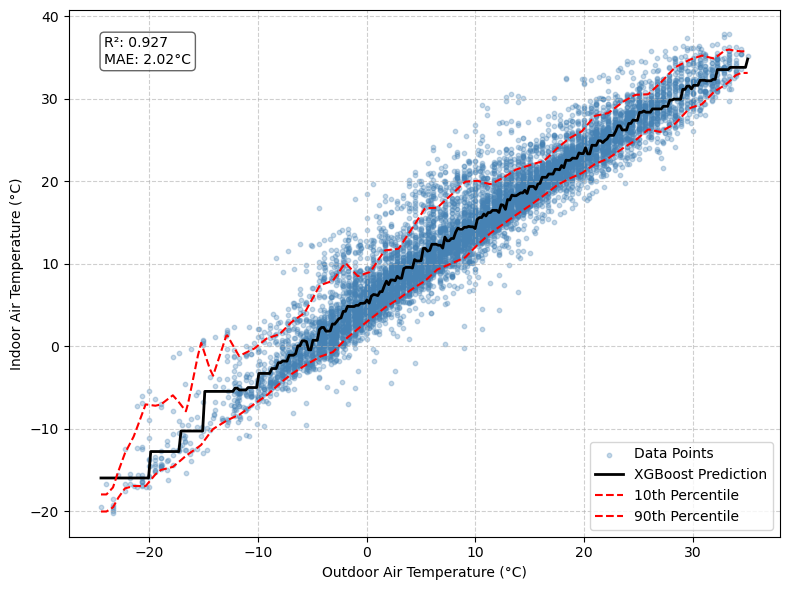

In [23]:

for file, label in zip(cases, labels):
    print(f"\nProcessing case: {label}")

    df = pd.read_excel(file, sheet_name="Model_grey-box3")
    x = pd.to_numeric(df["te"], errors="coerce")         # Outdoor
    y = pd.to_numeric(df["tair,model"], errors="coerce") # Indoor
    df = pd.DataFrame({"x": x, "y": y}).dropna()
    X_train, X_test, y_train, y_test = train_test_split(
        df["x"].values.reshape(-1, 1), df["y"].values, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_all_scaled = scaler.transform(df["x"].values.reshape(-1, 1))

    model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"R²: {r2:.3f}, MAE: {mae:.2f}°C")
    x_range = np.linspace(df["x"].min(), df["x"].max(), 300).reshape(-1, 1)
    x_range_scaled = scaler.transform(x_range)
    y_range_pred = model.predict(x_range_scaled)

    df_sorted = df.sort_values("x").reset_index(drop=True)
    bins = np.linspace(df_sorted["x"].min(), df_sorted["x"].max(), 50)
    df_sorted["bin"] = pd.cut(df_sorted["x"], bins, include_lowest=True)
    binned = df_sorted.groupby("bin", observed=False).agg({
        "x": "mean",
        "y": [lambda x: np.percentile(x, 10), lambda x: np.percentile(x, 90)]
    }).dropna()
    binned.columns = ["x_center", "q10", "q90"]
    q10_interp = np.interp(df_sorted["x"], binned["x_center"], binned["q10"])
    q90_interp = np.interp(df_sorted["x"], binned["x_center"], binned["q90"])

    # XGBoost + Quantile Tube
    plt.figure(figsize=(8, 6))
    plt.scatter(df_sorted["x"], df_sorted["y"], alpha=0.3, color='steelblue', s=10, label="Data Points")
    plt.plot(x_range, y_range_pred, color="black", linewidth=2, label="XGBoost Prediction")
    plt.plot(df_sorted["x"], q10_interp, color="red", linestyle="--", label="10th Percentile")
    plt.plot(df_sorted["x"], q90_interp, color="red", linestyle="--", label="90th Percentile")
    plt.xlabel("Outdoor Air Temperature (°C)")
    plt.ylabel("Indoor Air Temperature (°C)")
    #plt.title(f"XGBoost Regression: {label}")
    plt.text(0.05, 0.95, f"R²: {r2:.3f}\nMAE: {mae:.2f}°C",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.6))
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"{label}_XGBoost_QuantileTube.png", dpi=300)
    plt.show()

    print(f"\nProcessing case: {label}")

    # Load and clean data
    df = pd.read_excel(file, sheet_name="Model_grey-box3")
    x = pd.to_numeric(df["te"], errors="coerce")         # Outdoor temperature
    y = pd.to_numeric(df["tair,model"], errors="coerce") # Indoor temperature
    df = pd.DataFrame({"x": x, "y": y}).dropna()


Processing case: 600FF
R²: 0.655, MAE: 7.37°C


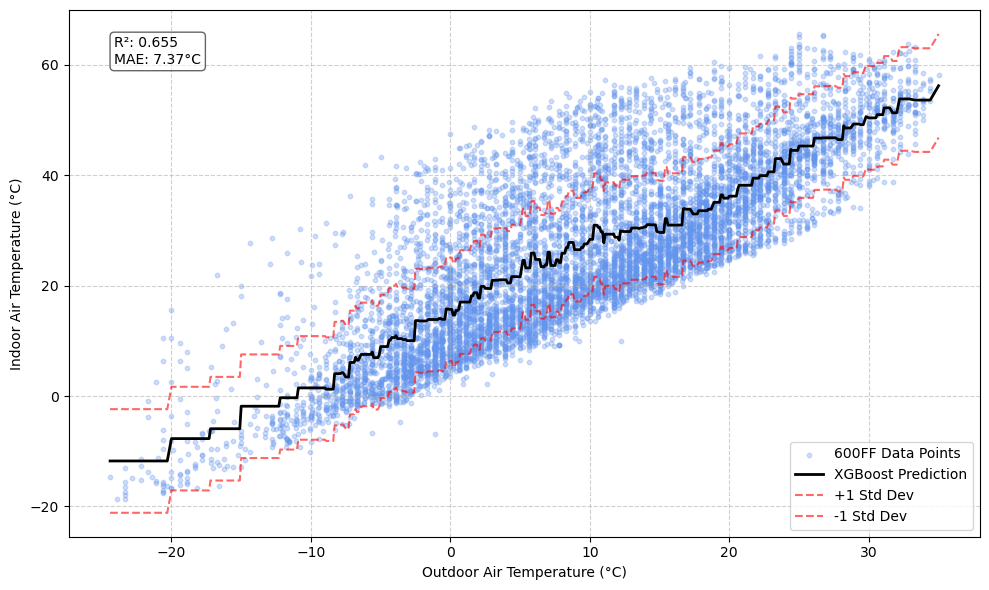


Processing case: 650FF
R²: 0.629, MAE: 8.34°C


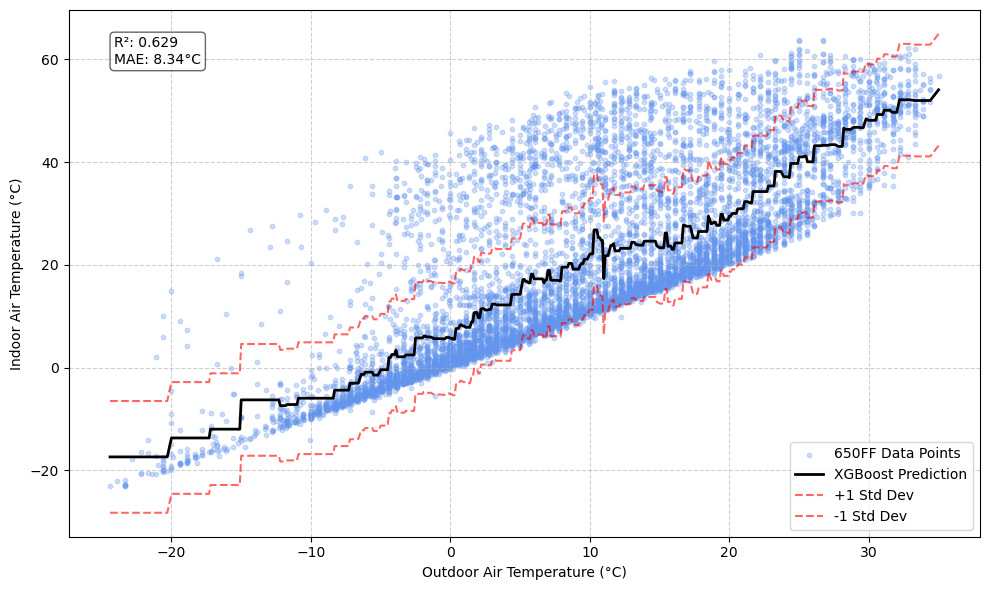


Processing case: 900FF
R²: 0.812, MAE: 3.14°C


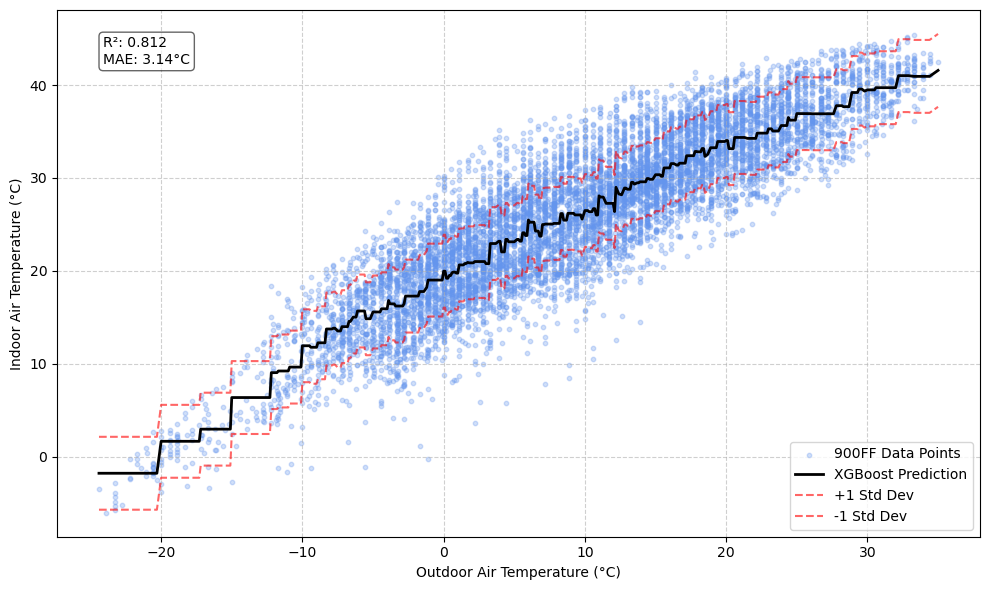


Processing case: 950FF
R²: 0.927, MAE: 2.03°C


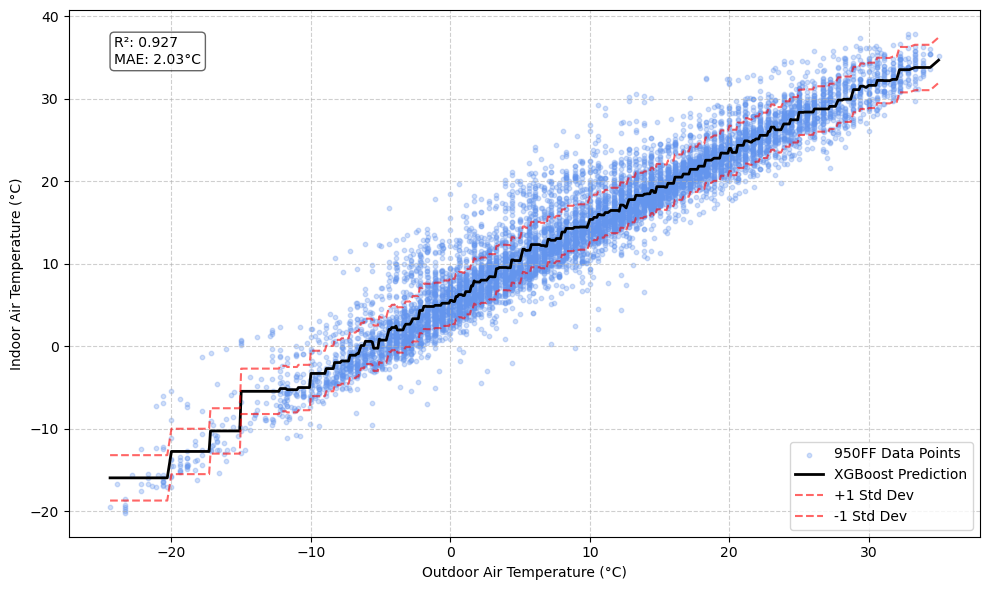

In [22]:
for file, label in zip(cases, labels):
    print(f"\nProcessing case: {label}")

    df = pd.read_excel(file, sheet_name="Model_grey-box3")
    x = pd.to_numeric(df["te"], errors="coerce")
    y = pd.to_numeric(df["tair,model"], errors="coerce")
    df = pd.DataFrame({"x": x, "y": y}).dropna()

    X_train, X_test, y_train, y_test = train_test_split(
        df["x"].values.reshape(-1, 1), df["y"].values, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_all_scaled = scaler.transform(df["x"].values.reshape(-1, 1))

    model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective="reg:squarederror", random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"R²: {r2:.3f}, MAE: {mae:.2f}°C")

    full_pred = model.predict(X_all_scaled)
    residuals = df["y"].values - full_pred
    std_dev = np.std(residuals)
    upper = full_pred + std_dev
    lower = full_pred - std_dev

    df_sorted = df.copy().reset_index(drop=True).sort_values("x")
    df_sorted["y_pred"] = full_pred
    df_sorted["upper"] = upper
    df_sorted["lower"] = lower
    # Prediction + Standard deviation
    plt.figure(figsize=10, 6)) #to differentiate between the two groups
    plt.scatter(df_sorted["x"], df_sorted["y"], alpha=0.3, color="cornflowerblue", s=10, label=f"{label} Data Points")
    plt.plot(df_sorted["x"], df_sorted["y_pred"], color="black", linewidth=2, label="XGBoost Prediction")
    plt.plot(df_sorted["x"], df_sorted["upper"], color="red", linestyle="--", alpha=0.6, label="+1 Std Dev")
    plt.plot(df_sorted["x"], df_sorted["lower"], color="red", linestyle="--", alpha=0.6, label="-1 Std Dev")
    plt.xlabel("Outdoor Air Temperature (°C)")
    plt.ylabel("Indoor Air Temperature (°C)")
    plt.text(0.05, 0.95, f"R²: {r2:.3f}\nMAE: {mae:.2f}°C",
             transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.6))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"{label}_XGBoost_StdDevTube.png", dpi=300)
    plt.show()

